In [1]:
# 对mpaq数据集进行分析
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

/home/pai/envs/T5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MPQADataset(Dataset):
  def __init__(self, tokenizer, dataset, type_path, max_len=512):

    self.data = dataset[type_path]
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.tokenizer.max_length = max_len
    self.tokenizer.model_max_length = max_len
    self.inputs = []
    self.targets = []

    self._build()

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  def _build(self):
    for idx in range(len(self.data)):
      input_, target = " ".join(self.data[idx]["words"]), "; ".join(self.data[idx]["spans"])
      input_ = input_ + " DSE:" + self.data[idx]["dse"]

      input_ = input_.lower() + ' </s>'
      target = target.lower() + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target],max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [3]:
def get_dataset(tokenizer, type_path, args):
    tokenizer.max_length = args.max_seq_length
    tokenizer.model_max_length = args.max_seq_length
    # dataset = load_dataset(args.data_dir)
    dataset = load_dataset("zhangxl2002/mpqa_ORL")
    return MPQADataset(tokenizer=tokenizer, dataset=dataset, type_path=type_path)

In [4]:
args_dict = dict(
    data_dir="zhangxl2002/mpqa_ORL",
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=256,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=10,
    gradient_accumulation_steps=16,
    n_gpu=1,
    seed=42,
)
args = argparse.Namespace(**args_dict)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")

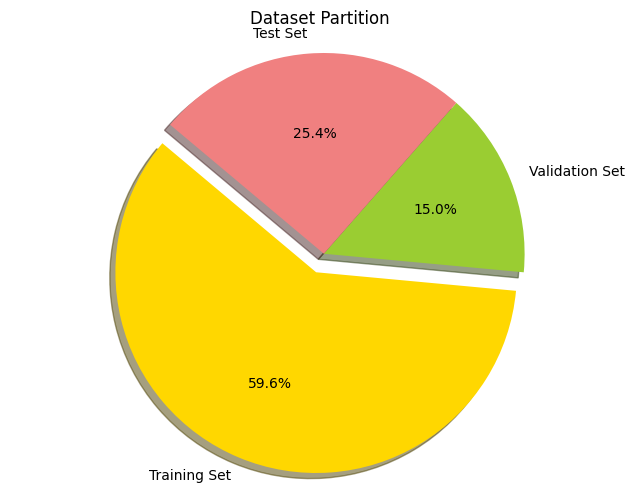

In [9]:
import matplotlib.pyplot as plt

# 数据集的大小
train_size = 3549
validation_size = 893
test_size = 1509

# 计算每个部分所占的比例
total_size = train_size + validation_size + test_size
train_percentage = train_size / total_size
validation_percentage = validation_size / total_size
test_percentage = test_size / total_size

# 绘制饼状图
labels = 'Training Set', 'Validation Set', 'Test Set'
sizes = [train_percentage, validation_percentage, test_percentage]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # 突出显示第一块

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # 保持圆形
plt.title('Dataset Partition')
plt.show()


In [10]:
spans = load_dataset("zhangxl2002/mpqa_ORL")['train']['spans']

Using the latest cached version of the dataset since zhangxl2002/mpqa_ORL couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/zhangxl2002___mpqa_orl/default/0.0.0/641feb73418f528f8cb804428dc1d23c9cc62ec5 (last modified on Tue May 14 16:41:54 2024).


In [11]:
len(spans)

3549

In [12]:
# 绘制柱状图
def plot_histogram(numbers,title):
    counter = Counter(numbers)
    numbers = list(counter.keys())
    frequencies = list(counter.values())
    
    # 绘制柱状图
    plt.bar(numbers, frequencies, align='center', alpha=0.5)
    plt.xlabel('lengths')
    plt.ylabel('count')
    plt.title(title,fontproperties='SimHei')
    
    plt.show()

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


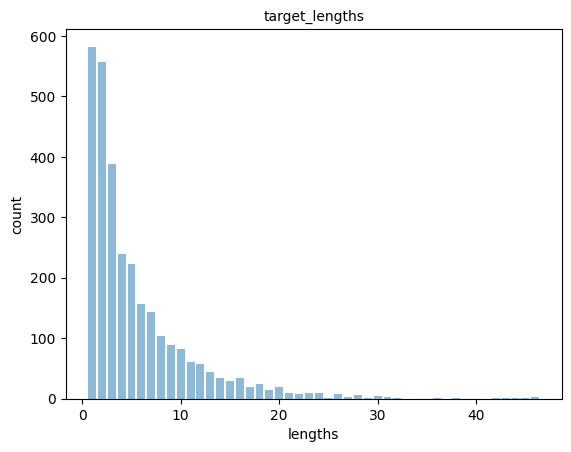

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


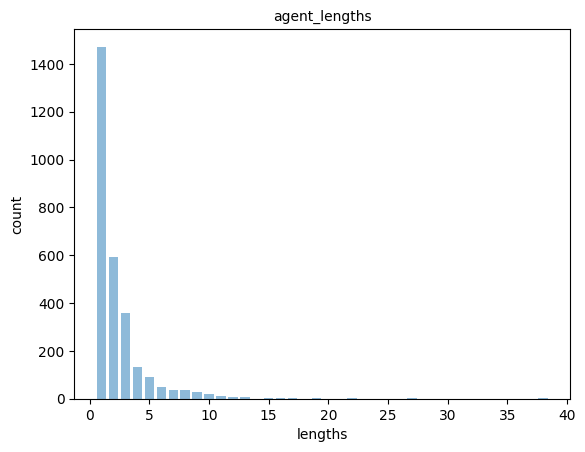

0th percentile: 1.0
25th percentile: 1.0
50th percentile (median): 1.0
75th percentile: 3.0
100th percentile: 38.0
0th percentile: 1.0
25th percentile: 2.0
50th percentile (median): 3.0
75th percentile: 7.0
100th percentile: 46.0


In [16]:
# 数据集target和agent长度分布
agent_lengths = []
target_lengths = []
for i in range(len(spans)):
    for j in range(len(spans[i])):
        if spans[i][j].startswith("AGENT:"):
            # print(spans[i][j])
            # print("len:",len(spans[i][j].split())-1)
            agent_lengths.append(len(spans[i][j].split())-1)
        elif spans[i][j].startswith("TARGET:"):
            target_lengths.append(len(spans[i][j].split())-1)

# 示例整数列表
# numbers = [1, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5]
plot_histogram(target_lengths,"target_lengths")
plot_histogram(agent_lengths,"agent_lengths")
percentiles = np.percentile(agent_lengths, [0, 25, 50, 75, 100])
print("0th percentile:", percentiles[0])
print("25th percentile:", percentiles[1])
print("50th percentile (median):", percentiles[2])
print("75th percentile:", percentiles[3])
print("100th percentile:", percentiles[4])

percentiles = np.percentile(target_lengths, [0, 25, 50, 75, 100])
print("0th percentile:", percentiles[0])
print("25th percentile:", percentiles[1])
print("50th percentile (median):", percentiles[2])
print("75th percentile:", percentiles[3])
print("100th percentile:", percentiles[4])

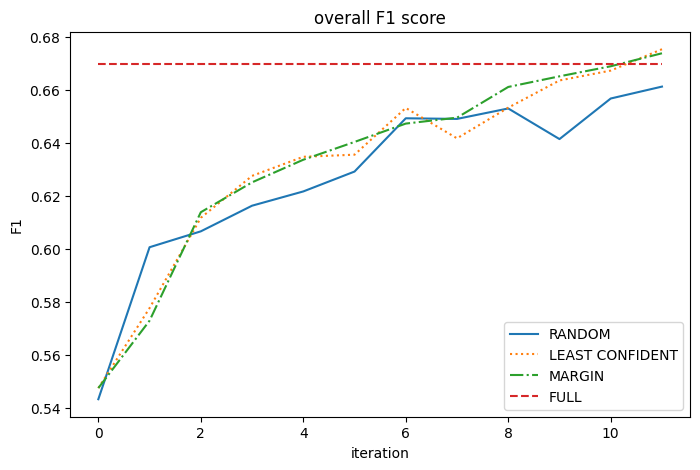

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这是你的两个二维数组
RANDOM_test_F1_overall = np.load("RANDOM_result/RANDOM_test_F1_overall_record.npy")[:-1]
BEAM_test_F1_overall = np.load("BEAM_result/BEAM_test_F1_overall_record.npy")[:-1]
MARGIN_test_F1_overall = np.load("MARGIN_result/MARGIN_test_F1_overall_record.npy")[:-1]
max_RANDOM_test_F1_overall = np.amax(RANDOM_test_F1_overall, axis=1)
max_BEAM_test_F1_overall = np.amax(BEAM_test_F1_overall, axis=1)
max_MARGIN_test_F1_overall = np.amax(MARGIN_test_F1_overall, axis=1)
FULL_test_F1_overall = np.array([0.669767441860465]*len(max_RANDOM_test_F1_overall))

RANDOM_test_F1_AGENT = np.load("RANDOM_result/RANDOM_test_F1_AGENT_record.npy")[:-1]
BEAM_test_F1_AGENT = np.load("BEAM_result/BEAM_test_F1_AGENT_record.npy")[:-1]
MARGIN_test_F1_AGENT = np.load("MARGIN_result/MARGIN_test_F1_AGENT_record.npy")[:-1]
max_RANDOM_test_F1_AGENT = np.amax(RANDOM_test_F1_AGENT, axis=1)
max_BEAM_test_F1_AGENT = np.amax(BEAM_test_F1_AGENT, axis=1)
max_MARGIN_test_F1_AGENT = np.amax(MARGIN_test_F1_AGENT, axis=1)
FULL_test_F1_AGENT = np.array([0.7665056360708534]*len(max_RANDOM_test_F1_AGENT))

RANDOM_test_F1_TARGET = np.load("RANDOM_result/RANDOM_test_F1_TARGET_record.npy")[:-1]
BEAM_test_F1_TARGET = np.load("BEAM_result/BEAM_test_F1_TARGET_record.npy")[:-1]
MARGIN_test_F1_TARGET = np.load("MARGIN_result/MARGIN_test_F1_TARGET_record.npy")[:-1]
max_RANDOM_test_F1_TARGET = np.amax(RANDOM_test_F1_TARGET, axis=1)
max_BEAM_test_F1_TARGET = np.amax(BEAM_test_F1_TARGET, axis=1)
max_MARGIN_test_F1_TARGET = np.amax(MARGIN_test_F1_TARGET, axis=1)
FULL_test_F1_TARGET = np.array([0.5721251523770825]*len(max_RANDOM_test_F1_TARGET))
# 绘制折线图

plt.figure(figsize=(8, 5))

plt.subplot(1,1,1)
plt.plot(max_RANDOM_test_F1_overall, label='RANDOM', linestyle='-')
plt.plot(max_BEAM_test_F1_overall, label='LEAST CONFIDENT', linestyle=':')
plt.plot(max_MARGIN_test_F1_overall, label='MARGIN', linestyle='-.')
plt.plot(FULL_test_F1_overall, linestyle="--",label='FULL')
plt.legend()
plt.title('overall F1 score')
plt.xlabel('iteration')
plt.ylabel('F1')

# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_F1_AGENT, label='RANDOM', linestyle='-')
# plt.plot(max_BEAM_test_F1_AGENT, label='LEAST CONFIDENT', linestyle=':')
# plt.plot(max_MARGIN_test_F1_AGENT, label='MARGIN', linestyle='-.')
# plt.plot(FULL_test_F1_AGENT, linestyle="--",label='FULL')
# plt.legend()
# plt.title('AGENT F1 score')
# plt.xlabel('iteration')
# plt.ylabel('F1')

# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_F1_TARGET, label='RANDOM', linestyle='-')
# plt.plot(max_BEAM_test_F1_TARGET, label='LEAST CONFIDENT', linestyle=':')
# plt.plot(max_MARGIN_test_F1_TARGET, label='MARGIN', linestyle='-.')
# plt.plot(FULL_test_F1_TARGET, linestyle="--",label='FULL')
# plt.legend()
# plt.title('TARGET F1 score')
# plt.xlabel('iteration')
# plt.ylabel('F1')


# 显示图形
plt.show()

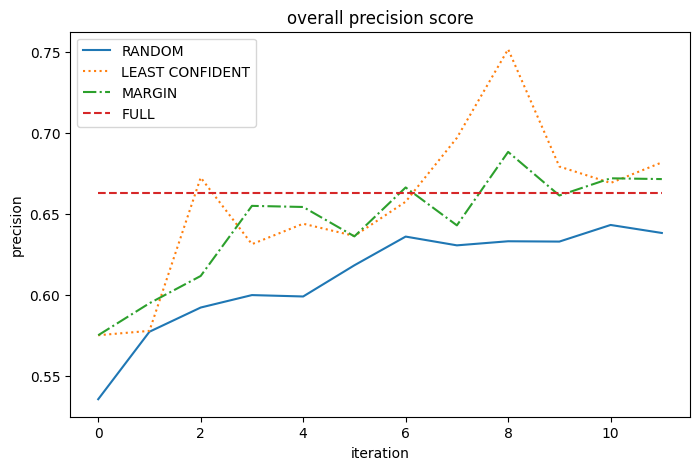

In [10]:
# 结果：precision
import numpy as np
import matplotlib.pyplot as plt

# 假设这是你的两个二维数组
RANDOM_test_precision_overall = np.load("RANDOM_result/RANDOM_test_precision_overall_record.npy")[:-1]
BEAM_test_precision_overall = np.load("BEAM_result/BEAM_test_precision_overall_record.npy")[:-1]
MARGIN_test_precision_overall = np.load("MARGIN_result/MARGIN_test_precision_overall_record.npy")[:-1]
max_RANDOM_test_precision_overall = np.amax(RANDOM_test_precision_overall, axis=1)
max_BEAM_test_precision_overall = np.amax(BEAM_test_precision_overall, axis=1)
max_MARGIN_test_precision_overall = np.amax(MARGIN_test_precision_overall, axis=1)
FULL_test_precision_overall = np.array([0.6629303442754203]*len(max_RANDOM_test_precision_overall))

RANDOM_test_precision_AGENT = np.load("RANDOM_result/RANDOM_test_precision_AGENT_record.npy")[:-1]
BEAM_test_precision_AGENT = np.load("BEAM_result/BEAM_test_precision_AGENT_record.npy")[:-1]
MARGIN_test_precision_AGENT = np.load("MARGIN_result/MARGIN_test_precision_AGENT_record.npy")[:-1]
max_RANDOM_test_precision_AGENT = np.amax(RANDOM_test_precision_AGENT, axis=1)
max_BEAM_test_precision_AGENT = np.amax(BEAM_test_precision_AGENT, axis=1)
max_MARGIN_test_precision_AGENT = np.amax(MARGIN_test_precision_AGENT, axis=1)
FULL_test_precision_AGENT = np.array([0.7368421052631579]*len(max_RANDOM_test_precision_AGENT))

RANDOM_test_precision_TARGET = np.load("RANDOM_result/RANDOM_test_precision_TARGET_record.npy")[:-1]
BEAM_test_precision_TARGET = np.load("BEAM_result/BEAM_test_precision_TARGET_record.npy")[:-1]
MARGIN_test_precision_TARGET = np.load("MARGIN_result/MARGIN_test_precision_TARGET_record.npy")[:-1]
max_RANDOM_test_precision_TARGET = np.amax(RANDOM_test_precision_TARGET, axis=1)
max_BEAM_test_precision_TARGET = np.amax(BEAM_test_precision_TARGET, axis=1)
max_MARGIN_test_precision_TARGET = np.amax(MARGIN_test_precision_TARGET, axis=1)
FULL_test_precision_TARGET = np.array([0.5837479270315091]*len(max_RANDOM_test_precision_TARGET))
# 绘制折线图
# plt.rc('font', size=12, weight='bold')

plt.figure(figsize=(8, 5))

plt.subplot(1,1,1)
plt.plot(max_RANDOM_test_precision_overall, label='RANDOM',linestyle='-')
plt.plot(max_BEAM_test_precision_overall, label='LEAST CONFIDENT',linestyle=':')
plt.plot(max_MARGIN_test_precision_overall, label='MARGIN',linestyle='-.')
plt.plot(FULL_test_precision_overall, linestyle="--",label='FULL')
plt.legend()
plt.title('overall precision score')
plt.xlabel('iteration')
plt.ylabel('precision')

# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_precision_AGENT, label='RANDOM',linestyle='-')
# plt.plot(max_BEAM_test_precision_AGENT, label='LEAST CONFIDENT',linestyle=':')
# plt.plot(max_MARGIN_test_precision_AGENT, label='MARGIN',linestyle='-.')
# plt.plot(FULL_test_precision_AGENT, linestyle="--",label='FULL')
# plt.legend()
# plt.title('AGENT precision score')
# plt.xlabel('iteration')
# plt.ylabel('precision')

# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_precision_TARGET, label='RANDOM',linestyle='-')
# plt.plot(max_BEAM_test_precision_TARGET, label='LEAST CONFIDENT',linestyle=':')
# plt.plot(max_MARGIN_test_precision_TARGET, label='MARGIN',linestyle='-.')
# plt.plot(FULL_test_precision_TARGET, linestyle="--",label='FULL')
# plt.legend()
# plt.title('TARGET precision score')
# plt.xlabel('iteration')
# plt.ylabel('precision')



#-------------------------------------------------------


RANDOM_test_recall_overall = np.load("RANDOM_result/RANDOM_test_recall_overall_record.npy")[:-1]
BEAM_test_recall_overall = np.load("BEAM_result/BEAM_test_recall_overall_record.npy")[:-1]
MARGIN_test_recall_overall = np.load("MARGIN_result/MARGIN_test_recall_overall_record.npy")[:-1]
max_RANDOM_test_recall_overall = np.amax(RANDOM_test_recall_overall, axis=1)
max_BEAM_test_recall_overall = np.amax(BEAM_test_recall_overall, axis=1)
max_MARGIN_test_recall_overall = np.amax(MARGIN_test_recall_overall, axis=1)
FULL_test_recall_overall = np.array([0.6767470371883939]*len(max_RANDOM_test_recall_overall))

RANDOM_test_recall_AGENT = np.load("RANDOM_result/RANDOM_test_recall_AGENT_record.npy")[:-1]
BEAM_test_recall_AGENT = np.load("BEAM_result/BEAM_test_recall_AGENT_record.npy")[:-1]
MARGIN_test_recall_AGENT = np.load("MARGIN_result/MARGIN_test_recall_AGENT_record.npy")[:-1]
max_RANDOM_test_recall_AGENT = np.amax(RANDOM_test_recall_AGENT, axis=1)
max_BEAM_test_recall_AGENT = np.amax(BEAM_test_recall_AGENT, axis=1)
max_MARGIN_test_recall_AGENT = np.amax(MARGIN_test_recall_AGENT, axis=1)
FULL_test_recall_AGENT = np.array([0.7986577181208053]*len(max_RANDOM_test_recall_AGENT))

RANDOM_test_recall_TARGET = np.load("RANDOM_result/RANDOM_test_recall_TARGET_record.npy")[:-1]
BEAM_test_recall_TARGET = np.load("BEAM_result/BEAM_test_recall_TARGET_record.npy")[:-1]
MARGIN_test_recall_TARGET = np.load("MARGIN_result/MARGIN_test_recall_TARGET_record.npy")[:-1]
max_RANDOM_test_recall_TARGET = np.amax(RANDOM_test_recall_TARGET, axis=1)
max_BEAM_test_recall_TARGET = np.amax(BEAM_test_recall_TARGET, axis=1)
max_MARGIN_test_recall_TARGET = np.amax(MARGIN_test_recall_TARGET, axis=1)
FULL_test_recall_TARGET = np.array([0.5609561752988048]*len(max_RANDOM_test_recall_TARGET))
# 绘制折线图


# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_recall_overall, label='RANDOM',linestyle='-')
# plt.plot(max_BEAM_test_recall_overall, label='LEAST CONFIDENT',linestyle=':')
# plt.plot(max_MARGIN_test_recall_overall, label='MARGIN',linestyle='-.')
# plt.plot(FULL_test_recall_overall, linestyle="--",label='FULL')
# plt.legend()
# plt.title('overall recall score')
# plt.xlabel('iteration')
# plt.ylabel('recall')

# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_recall_AGENT, label='RANDOM',linestyle='-')
# plt.plot(max_BEAM_test_recall_AGENT, label='LEAST CONFIDENT',linestyle=':')
# plt.plot(max_MARGIN_test_recall_AGENT, label='MARGIN',linestyle='-.')
# plt.plot(FULL_test_recall_AGENT, linestyle="--",label='FULL')
# plt.legend()
# plt.title('AGENT recall score')
# plt.xlabel('iteration')
# plt.ylabel('recall')

# plt.subplot(1,1,1)
# plt.plot(max_RANDOM_test_recall_TARGET, label='RANDOM',linestyle='-')
# plt.plot(max_BEAM_test_recall_TARGET, label='LEAST CONFIDENT',linestyle=':')
# plt.plot(max_MARGIN_test_recall_TARGET, label='MARGIN',linestyle='-.')
# plt.plot(FULL_test_recall_TARGET, linestyle="--",label='FULL')
# plt.legend()
# plt.title('TARGET recall score')
# plt.xlabel('iteration')
# plt.ylabel('recall')

plt.show()




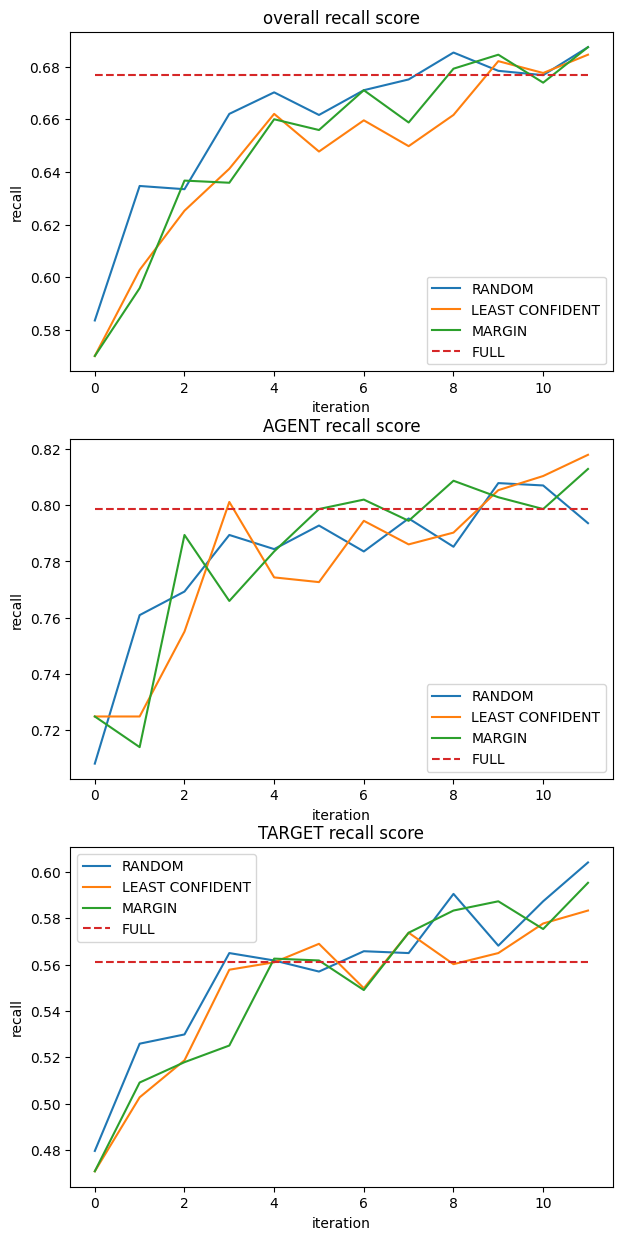

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这是你的两个二维数组
RANDOM_test_recall_overall = np.load("RANDOM_result/RANDOM_test_recall_overall_record.npy")[:-1]
BEAM_test_recall_overall = np.load("BEAM_result/BEAM_test_recall_overall_record.npy")[:-1]
MARGIN_test_recall_overall = np.load("MARGIN_result/MARGIN_test_recall_overall_record.npy")[:-1]
max_RANDOM_test_recall_overall = np.amax(RANDOM_test_recall_overall, axis=1)
max_BEAM_test_recall_overall = np.amax(BEAM_test_recall_overall, axis=1)
max_MARGIN_test_recall_overall = np.amax(MARGIN_test_recall_overall, axis=1)
FULL_test_recall_overall = np.array([0.6767470371883939]*len(max_RANDOM_test_recall_overall))

RANDOM_test_recall_AGENT = np.load("RANDOM_result/RANDOM_test_recall_AGENT_record.npy")[:-1]
BEAM_test_recall_AGENT = np.load("BEAM_result/BEAM_test_recall_AGENT_record.npy")[:-1]
MARGIN_test_recall_AGENT = np.load("MARGIN_result/MARGIN_test_recall_AGENT_record.npy")[:-1]
max_RANDOM_test_recall_AGENT = np.amax(RANDOM_test_recall_AGENT, axis=1)
max_BEAM_test_recall_AGENT = np.amax(BEAM_test_recall_AGENT, axis=1)
max_MARGIN_test_recall_AGENT = np.amax(MARGIN_test_recall_AGENT, axis=1)
FULL_test_recall_AGENT = np.array([0.7986577181208053]*len(max_RANDOM_test_recall_AGENT))

RANDOM_test_recall_TARGET = np.load("RANDOM_result/RANDOM_test_recall_TARGET_record.npy")[:-1]
BEAM_test_recall_TARGET = np.load("BEAM_result/BEAM_test_recall_TARGET_record.npy")[:-1]
MARGIN_test_recall_TARGET = np.load("MARGIN_result/MARGIN_test_recall_TARGET_record.npy")[:-1]
max_RANDOM_test_recall_TARGET = np.amax(RANDOM_test_recall_TARGET, axis=1)
max_BEAM_test_recall_TARGET = np.amax(BEAM_test_recall_TARGET, axis=1)
max_MARGIN_test_recall_TARGET = np.amax(MARGIN_test_recall_TARGET, axis=1)
FULL_test_recall_TARGET = np.array([0.5609561752988048]*len(max_RANDOM_test_recall_TARGET))
# 绘制折线图

plt.figure(figsize=(7, 15))

plt.subplot(3,1,1)
plt.plot(max_RANDOM_test_recall_overall, label='RANDOM')
plt.plot(max_BEAM_test_recall_overall, label='LEAST CONFIDENT')
plt.plot(max_MARGIN_test_recall_overall, label='MARGIN')
plt.plot(FULL_test_recall_overall, linestyle="--",label='FULL')
plt.legend()
plt.title('overall recall score')
plt.xlabel('iteration')
plt.ylabel('recall')

plt.subplot(3,1,2)
plt.plot(max_RANDOM_test_recall_AGENT, label='RANDOM')
plt.plot(max_BEAM_test_recall_AGENT, label='LEAST CONFIDENT')
plt.plot(max_MARGIN_test_recall_AGENT, label='MARGIN')
plt.plot(FULL_test_recall_AGENT, linestyle="--",label='FULL')
plt.legend()
plt.title('AGENT recall score')
plt.xlabel('iteration')
plt.ylabel('recall')

plt.subplot(3,1,3)
plt.plot(max_RANDOM_test_recall_TARGET, label='RANDOM')
plt.plot(max_BEAM_test_recall_TARGET, label='LEAST CONFIDENT')
plt.plot(max_MARGIN_test_recall_TARGET, label='MARGIN')
plt.plot(FULL_test_recall_TARGET, linestyle="--",label='FULL')
plt.legend()
plt.title('TARGET recall score')
plt.xlabel('iteration')
plt.ylabel('recall')

# # 添加图例、标题和标签
# plt.legend()
# plt.title('overall recall score')
# plt.xlabel('iter num')
# plt.ylabel('overall recall')

# 显示图形
plt.show()

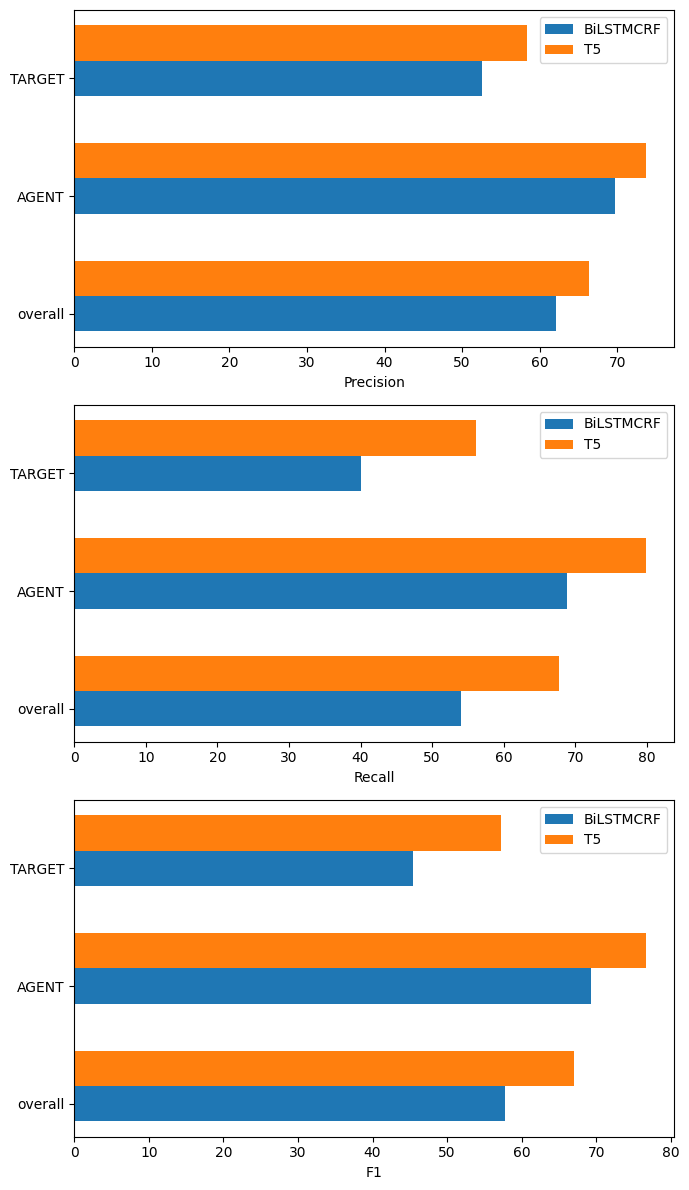

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['overall', 'AGENT', 'TARGET']
bilstmcrf_precision = [62.06, 69.71, 52.61]
bilstmcrf_recall = [54.09, 68.90, 40.03]
bilstmcrf_f1 = [57.80, 69.30, 45.47]


t5_precision = [66.29, 73.68, 58.37]  
t5_recall = [67.67, 79.87, 56.10]    
t5_f1 = [66.98, 76.65, 57.21]        

# 设置柱状图高度
bar_height = 0.3

# 设置柱状图位置
y = np.arange(len(categories))

# 创建子图
fig, axs = plt.subplots(3, 1, figsize=(7, 12))

# 绘制每个子图
axs[0].barh(y, bilstmcrf_precision, bar_height, label='BiLSTMCRF')
axs[0].barh(y + bar_height, t5_precision, bar_height, label='T5')
axs[0].set_yticks(y)
axs[0].set_yticklabels(categories)
axs[0].set_xlabel("Precision")
axs[0].legend()

axs[1].barh(y, bilstmcrf_recall, bar_height, label='BiLSTMCRF')
axs[1].barh(y + bar_height, t5_recall, bar_height, label='T5')
axs[1].set_yticks(y)
axs[1].set_yticklabels(categories)
axs[1].set_xlabel("Recall")
axs[1].legend()

axs[2].barh(y, bilstmcrf_f1, bar_height, label='BiLSTMCRF')
axs[2].barh(y + bar_height, t5_f1, bar_height, label='T5')
axs[2].set_yticks(y)
axs[2].set_yticklabels(categories)
axs[2].set_xlabel("F1")
axs[2].legend()

# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()


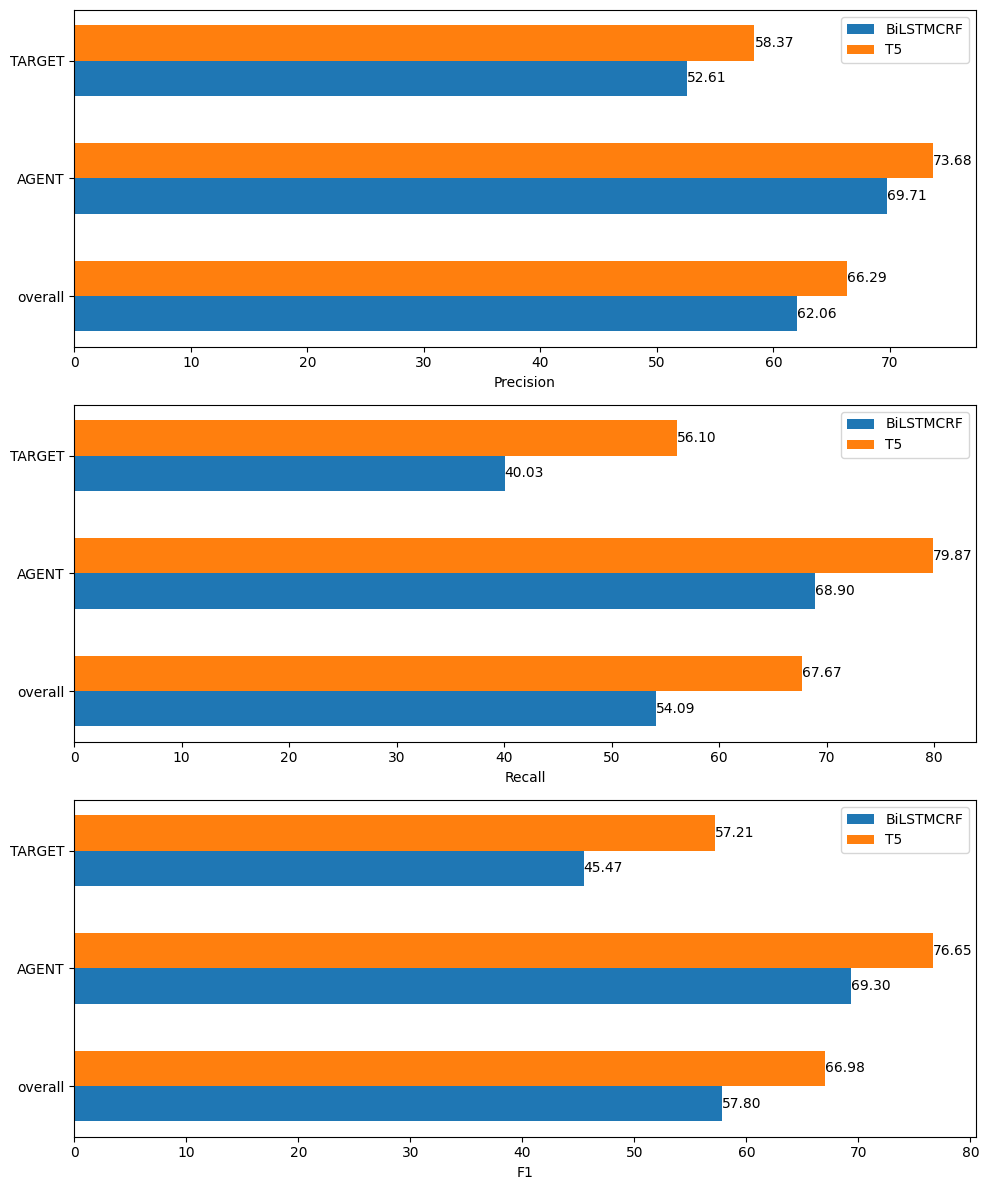

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['overall', 'AGENT', 'TARGET']
bilstmcrf_precision = [62.06, 69.71, 52.61]
bilstmcrf_recall = [54.09, 68.90, 40.03]
bilstmcrf_f1 = [57.80, 69.30, 45.47]

t5_precision = [66.29, 73.68, 58.37]  
t5_recall = [67.67, 79.87, 56.10]    
t5_f1 = [66.98, 76.65, 57.21]        

# 设置柱状图高度
bar_height = 0.3

# 设置柱状图位置
y = np.arange(len(categories))

# 创建子图
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# 函数：在柱状图上显示数值
def add_labels(ax, bars, values):
    for bar, value in zip(bars, values):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center')

# 绘制每个子图
bars1 = axs[0].barh(y, bilstmcrf_precision, bar_height, label='BiLSTMCRF')
bars2 = axs[0].barh(y + bar_height, t5_precision, bar_height, label='T5')
add_labels(axs[0], bars1, bilstmcrf_precision)
add_labels(axs[0], bars2, t5_precision)
axs[0].set_yticks(y + bar_height / 2)
axs[0].set_yticklabels(categories)
axs[0].set_xlabel("Precision")
axs[0].legend()

bars3 = axs[1].barh(y, bilstmcrf_recall, bar_height, label='BiLSTMCRF')
bars4 = axs[1].barh(y + bar_height, t5_recall, bar_height, label='T5')
add_labels(axs[1], bars3, bilstmcrf_recall)
add_labels(axs[1], bars4, t5_recall)
axs[1].set_yticks(y + bar_height / 2)
axs[1].set_yticklabels(categories)
axs[1].set_xlabel("Recall")
axs[1].legend()

bars5 = axs[2].barh(y, bilstmcrf_f1, bar_height, label='BiLSTMCRF')
bars6 = axs[2].barh(y + bar_height, t5_f1, bar_height, label='T5')
add_labels(axs[2], bars5, bilstmcrf_f1)
add_labels(axs[2], bars6, t5_f1)
axs[2].set_yticks(y + bar_height / 2)
axs[2].set_yticklabels(categories)
axs[2].set_xlabel("F1")
axs[2].legend()

# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()
